In [29]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, MaxPooling1D, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import SpatialDropout1D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import warnings
import os
warnings.filterwarnings('ignore')

In [30]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\udayj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\udayj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\udayj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\udayj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [43]:

print("Loading dataset...")
df = pd.read_csv('COVIDSenti-main/COVIDSenti-A.csv') 


df = df.sample(n=27000, random_state=42)

print(f"\nSampled dataset shape: {df.shape}")
print("\nFirst few rows of the sampled dataset:")
print(df.head())

Loading dataset...

Sampled dataset shape: (27000, 2)

First few rows of the sampled dataset:
                                                   tweet label
2308   Stay safe and healthy my moots whose countries...   neu
22404    This  #COVID2019 Corona Virus is Thanos Crazy..   neg
23397  End of the world: Coronavirus panic and Africa...   neu
25058  To prevent spread of COVID-19, Hong Kong Dioce...   neu
2664   Chinese leader warns of 'grave' coronavirus cr...   neu



Missing values:
tweet    0
label    0
dtype: int64

Label distribution:
label
neu    20634
neg     4574
pos     1792
Name: count, dtype: int64

Label percentages:
label
neu    76.42
neg    16.94
pos     6.64
Name: proportion, dtype: float64


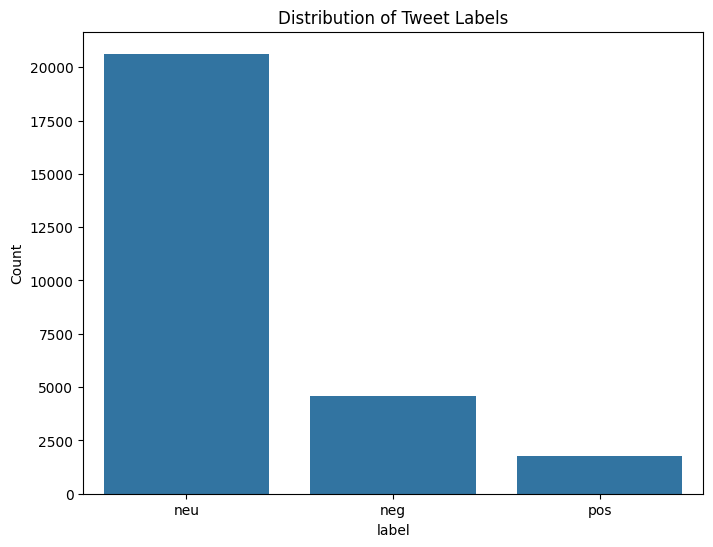


Cleaning and preprocessing tweets...


In [44]:

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# If any missing values, fill them
if df.isnull().sum().sum() > 0:
    df['tweet'].fillna('', inplace=True)
    df['label'].fillna(df['label'].mode()[0], inplace=True)

# Check label distribution
print("\nLabel distribution:")
label_counts = df['label'].value_counts()
print(label_counts)
print("\nLabel percentages:")
print((df['label'].value_counts(normalize=True) * 100).round(2))

# Plot label distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Tweet Labels')
plt.ylabel('Count')
plt.savefig('label_distribution.png')
plt.show()

# 2. Data cleaning and preprocessing
print("\nCleaning and preprocessing tweets...")

# Text cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove user mentions
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags symbol (but keep the word)
    text = re.sub(r'#', '', text)
    
    # Remove punctuation
    text = re.sub(f'[{string.punctuation}]', ' ', text)
    
    # Remove digits
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Tokenization, stopword removal and lemmatization
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Clean text
    text = clean_text(text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    
    return ' '.join(tokens)

In [45]:
df['processed_tweet'] = df['tweet'].apply(preprocess_text)

print("\nSample processed tweets:")
sample_df = pd.DataFrame({
    'original': df['tweet'].head(3),
    'processed': df['processed_tweet'].head(3)
})
print(sample_df)



Sample processed tweets:
                                                original  \
2308   Stay safe and healthy my moots whose countries...   
22404    This  #COVID2019 Corona Virus is Thanos Crazy..   
23397  End of the world: Coronavirus panic and Africa...   

                                               processed  
2308   stay safe healthy moot whose country get infec...  
22404                    covid corona virus thanos crazy  
23397  end world coronavirus panic african locust pla...  


In [46]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
num_classes = len(label_encoder.classes_)
print(f"\nNumber of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

# 3. Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_tweet'], 
    df['label_encoded'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df['label_encoded']
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")



Number of classes: 3
Classes: ['neg' 'neu' 'pos']

Training set size: 21600
Testing set size: 5400


In [47]:
MAX_NUM_WORDS = 50000  # Maximum number of words in the vocabulary
MAX_SEQUENCE_LENGTH = 50  # Maximum length of each tweet sequence
EMBEDDING_DIM = 100  # Dimension of the GloVe embeddings
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.0005

print("\nTokenizing and padding sequences...")
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens")

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)

# Convert labels to categorical format
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Calculate class weights to handle imbalance
print("\nHandling class imbalance...")
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"Class weights: {class_weight_dict}")

# Load GloVe embeddings
print("\nLoading GloVe embeddings...")
GLOVE_DIR = '.'  # Directory where the GloVe file is stored

# Download GloVe if not already present
if not os.path.exists('glove.6B.100d.txt'):
    print("Downloading GloVe embeddings...")
    import urllib.request
    import zipfile
    
    # Download the file
    glove_url = "https://nlp.stanford.edu/data/glove.6B.zip"
    urllib.request.urlretrieve(glove_url, "glove.6B.zip")
    
    # Extract the file
    with zipfile.ZipFile("glove.6B.zip", 'r') as zip_ref:
        zip_ref.extractall(".")
    
    print("GloVe embeddings downloaded and extracted.")


Tokenizing and padding sequences...
Found 21295 unique tokens

Handling class imbalance...
Class weights: {0: 1.9677507515714676, 1: 0.43617859090082994, 2: 5.02092050209205}

Loading GloVe embeddings...


In [48]:
embeddings_index = {}
with open(os.path.join(GLOVE_DIR, f'glove.6B.{EMBEDDING_DIM}d.txt'), encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(f"Found {len(embeddings_index)} word vectors in GloVe.")

# Prepare embedding matrix
embedding_matrix = np.zeros((min(MAX_NUM_WORDS, len(word_index) + 1), EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Create validation split with stratification to maintain class distribution
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_pad, y_train_cat, 
    test_size=VALIDATION_SPLIT, 
    random_state=42, 
    stratify=y_train
)


Found 400000 word vectors in GloVe.


In [49]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Embedding, SpatialDropout1D, Conv1D, MaxPooling1D, 
    BatchNormalization, GlobalAveragePooling1D, GlobalMaxPooling1D, 
    Dense, Dropout, concatenate
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l2
import numpy as np

print("\nBuilding improved CNN model...")

# Define input
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Embedding layer with GloVe weights
x = Embedding(min(MAX_NUM_WORDS, len(word_index) + 1),
              EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=True)(inputs)

# Add spatial dropout to prevent overfitting in the embedding layer
x = SpatialDropout1D(0.2)(x)  # Reduced dropout rate

# First convolutional block
x = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.0005))(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)

# Second convolutional block
x = Conv1D(256, 3, padding='same', activation='elu', kernel_regularizer=l2(0.0005))(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)

# Third convolutional block with residual connection
x = Conv1D(256, 3, padding='same', activation='elu', kernel_regularizer=l2(0.0005))(x)
x = BatchNormalization()(x)

# Global average pooling and global max pooling combined
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
concatenated = concatenate([avg_pool, max_pool])

# Dense layers with regularization
x = Dense(256, activation='elu', kernel_regularizer=l2(0.0005))(concatenated)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='elu', kernel_regularizer=l2(0.0005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Create the functional model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with a lower learning rate and AMSGrad optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0003, amsgrad=True),
    metrics=['accuracy']
)

print(model.summary())

# Define a more sophisticated learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    elif epoch < 10:
        return lr * 0.8
    else:
        return lr * 0.5

lr_scheduler = LearningRateScheduler(scheduler)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,  # Increased patience
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

# Add class weights with adjusted values based on the report
# The 'pos' class seems to have low precision, adjusting weights accordingly
adjusted_class_weight_dict = {
    0: 1.5,  # neg (adjust as needed)
    1: 1.0,  # neu
    2: 2.0   # pos (increased weight to address low precision)
}

# Data augmentation for training (if applicable for text)
def create_augmented_data(X_train, y_train, augmentation_factor=0.3):
    """Create augmented data by applying small random perturbations"""
    augmented_X = []
    augmented_y = []
    
    # Get indices of minority classes
    pos_indices = np.where(np.argmax(y_train, axis=1) == 2)[0]
    neg_indices = np.where(np.argmax(y_train, axis=1) == 0)[0]
    
    # Randomly select sequences to augment
    selected_indices = np.concatenate([
        np.random.choice(pos_indices, size=int(len(pos_indices) * augmentation_factor)),
        np.random.choice(neg_indices, size=int(len(neg_indices) * augmentation_factor))
    ])
    
    for idx in selected_indices:
        sequence = X_train[idx].copy()
        # Apply random word dropout (set 10-15% of tokens to 0)
        mask = np.random.rand(len(sequence)) > 0.15
        augmented_sequence = sequence * mask
        augmented_X.append(augmented_sequence)
        augmented_y.append(y_train[idx])
    
    # Combine original and augmented data
    return np.vstack([X_train, np.array(augmented_X)]), np.vstack([y_train, np.array(augmented_y)])

# Apply data augmentation if needed
X_train_augmented, y_train_augmented = create_augmented_data(X_train_final, y_train_final)


Building improved CNN model...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 50)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_5 (Embedding)       │ (None, 50, 100)           │       2,129,600 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ spatial_dropout1d_4           │ (None, 50, 100)           │               0 │ embedding_5[0][0]          │
│ (SpatialDropout1D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_18 (Conv1D)            │ (None, 50, 128)           │          38,528 │ spatial_dropout1d_4[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_13        │ (None, 50, 128)           │             512 │ conv1d_18[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_10              │ (None, 25, 128)           │               0 │ batch_normalization_13[0]… │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_19 (Conv1D)            │ (None, 25, 256)           │          98,560 │ max_pooling1d_10[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_14        │ (None, 25, 256)           │           1,024 │ conv1d_19[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_11              │ (None, 12, 256)           │               0 │ batch_normalization_14[0]… │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_20 (Conv1D)            │ (None, 12, 256)           │         196,864 │ max_pooling1d_11[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_15        │ (None, 12, 256)           │           1,024 │ conv1d_20[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d_2    │ (None, 256)               │               0 │ batch_normalization_15[0]… │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling1d_2        │ (None, 256)               │               0 │ batch_normalization_15[0]… │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 2,632,259 (10.04 MB)

 Trainable params: 2,630,211 (10.03 MB)

 Non-trainable params: 2,048 (8.00 KB)

None



Training the model with augmented data...
Epoch 1/50
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4055 - loss: 2.1763 
Epoch 1: val_loss improved from inf to 1.42945, saving model to best_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.4059 - loss: 2.1751 - val_accuracy: 0.5574 - val_loss: 1.4295 - learning_rate: 3.0000e-04
Epoch 2/50
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5960 - loss: 1.6778
Epoch 2: val_loss improved from 1.42945 to 1.19690, saving model to best_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.5961 - loss: 1.6776 - val_accuracy: 0.7458 - val_loss: 1.1969 - learning_rate: 3.0000e-04
Epoch 3/50
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6685 - loss: 1.5417
Epoch 3: val_loss improved from 1.19690 to 1.10960, saving model to best_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.6686 - loss: 1.5415 - val_accuracy: 0.7634 - val_loss: 1.1096 - learning_rate: 3.0000e-04
Epoch 4/50
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7262 - loss: 1.3755 
Epoch 4: val_loss improved from 1.10960 to 1.06269, saving model to best_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.7262 - loss: 1.3754 - val_accuracy: 0.7847 - val_loss: 1.0627 - learning_rate: 3.0000e-04
Epoch 5/50
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7708 - loss: 1.2303
Epoch 5: val_loss improved from 1.06269 to 1.01432, saving model to best_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.7708 - loss: 1.2303 - val_accuracy: 0.7861 - val_loss: 1.0143 - learning_rate: 3.0000e-04
Epoch 6/50
324/326 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7959 - loss: 1.1363
Epoch 6: val_loss improved from 1.01432 to 0.95094, saving model to best_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7960 - loss: 1.1362 - val_accuracy: 0.8162 - val_loss: 0.9509 - learning_rate: 2.4000e-04
Epoch 7/50
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8245 - loss: 1.0298
Epoch 7: val_loss improved from 0.95094 to 0.93416, saving model to best_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8245 - loss: 1.0297 - val_accuracy: 0.8227 - val_loss: 0.9342 - learning_rate: 1.9200e-04
Epoch 8/50
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8470 - loss: 0.9589
Epoch 8: val_loss did not improve from 0.93416
326/326 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8470 - loss: 0.9589 - val_accuracy: 0.7861 - val_loss: 1.0114 - learning_rate: 1.5360e-04
Epoch 9/50
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8602 - loss: 0.9063
Epoch 9: val_loss did not improve from 0.93416
326/326 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8602 - loss: 0.9063 - val_accuracy: 0.7875 - val_loss: 1.0023 - learning_rate: 1.2288e-04
Epoch 10/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8765 - loss: 0.8480
Epoch 10: val_loss did not improve from 0.93416

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.9152004066854715e-05.
326/326 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8765 - loss: 0.8480

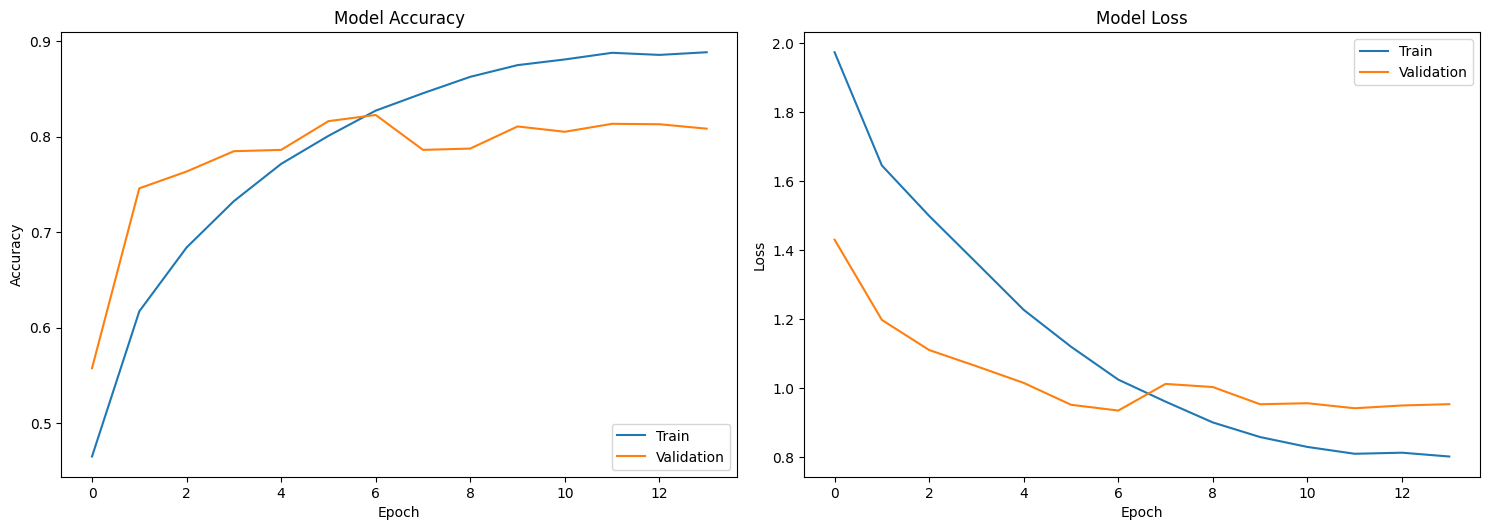


Evaluating the model...
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8346 - loss: 0.9107 
Test Loss: 0.9244
Test Accuracy: 82.44%
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   

Classification Report:
              precision    recall  f1-score   support

         neg       0.66      0.68      0.67       915
         neu       0.88      0.90      0.89      4127
         pos       0.50      0.37      0.42       358

    accuracy                           0.82      5400
   macro avg       0.68      0.65      0.66      5400
weighted avg       0.82      0.82      0.82      5400



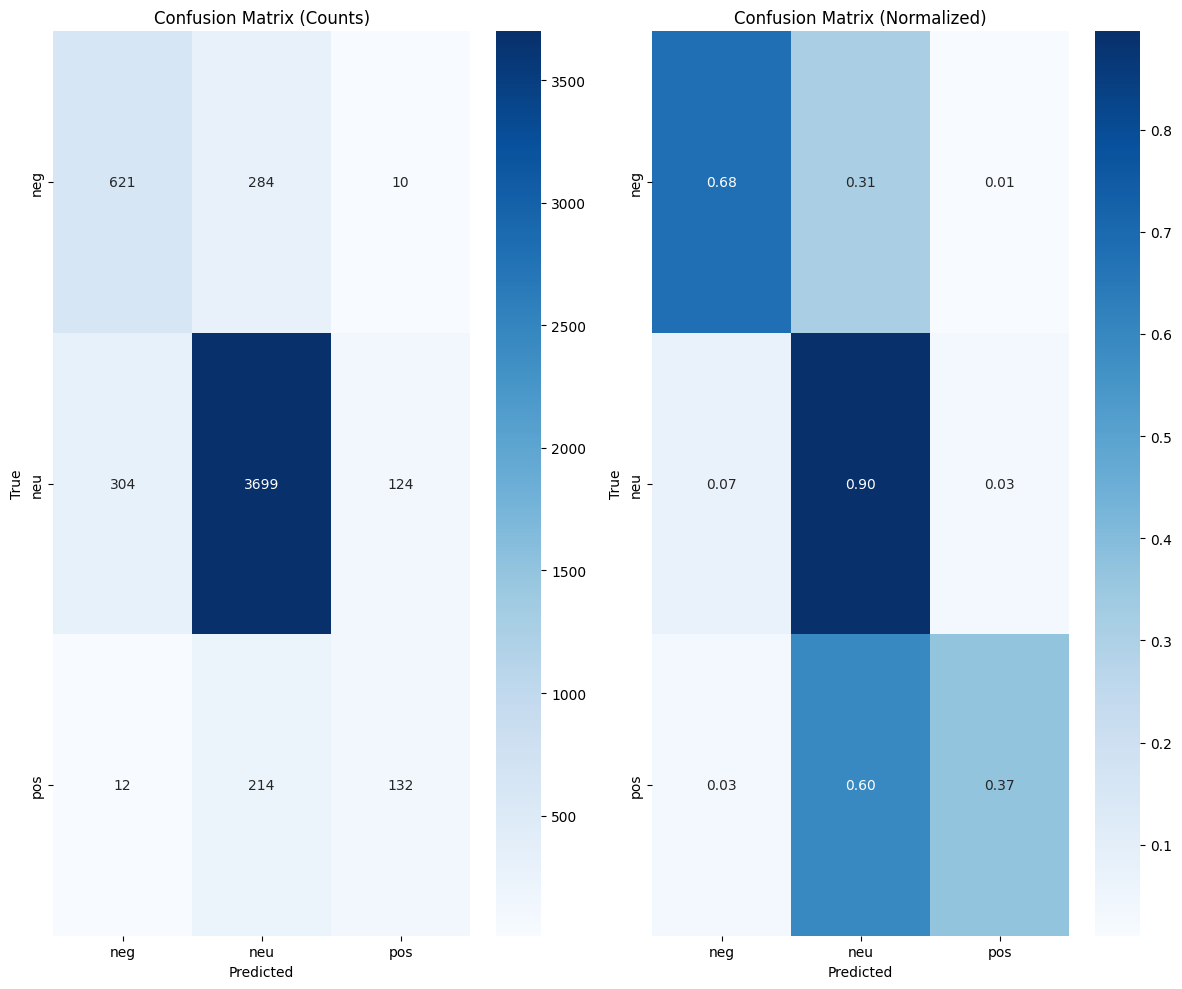

In [50]:
print("\nTraining the model with augmented data...")
history = model.fit(
    X_train_augmented, 
    y_train_augmented,
    epochs=50,  # Increase epochs, early stopping will prevent overfitting
    batch_size=64,  # Adjust batch size to match your GPU/CPU capabilities
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, checkpoint, reduce_lr, lr_scheduler],
    class_weight=adjusted_class_weight_dict,
    verbose=1
)

# Plot training history with more detail
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

if 'lr' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['lr'])
    plt.title('Learning Rate')
    plt.ylabel('Learning Rate')
    plt.xlabel('Epoch')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Evaluate the model with more metrics
print("\nEvaluating the model...")
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test_cat, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Get predictions and probabilities
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_decoded = np.argmax(y_test_cat, axis=1)

# Classification report with more detailed metrics
print("\nClassification Report:")
report = classification_report(y_test_decoded, y_pred, target_names=label_encoder.classes_, output_dict=True)
print(classification_report(y_test_decoded, y_pred, target_names=label_encoder.classes_))

# Confusion matrix with percentage normalization
conf_matrix = confusion_matrix(y_test_decoded, y_pred)
plt.figure(figsize=(12, 10))

# Plot raw counts
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Counts)')

# Plot percentages (normalized by row)
plt.subplot(1, 2, 2)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Normalized)')

plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()


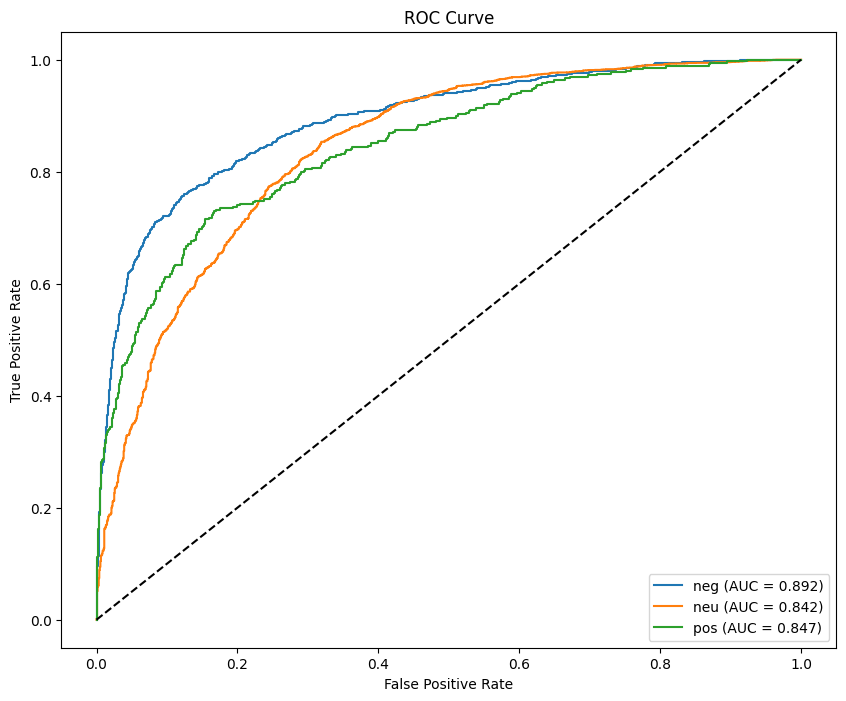

In [51]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i, label in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_cat[:, i], y_pred_probs[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')
plt.show()

# Save the high-performing model
model.save('improved_sentiment_model.keras')  